In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from pprint import pprint
from skimage.io import imread
import utils
import torch
from torch import nn
import torchvision
from torchvision.transforms import ToTensor
print(f'Pytorch version: {torch.__version__}, Torchvision version: {torchvision.__version__}')
from PIL import Image

Pytorch version: 2.0.0+cpu, Torchvision version: 0.15.1+cpu


In [2]:
path=glob.glob(os.path.join('MURA-v1.1','*','*','*', '*','*.png'))
pprint(path)


['MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00031\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00031\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00034\\study1_positive\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00034\\study1_positive\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient0

We try to concatenate all the info about the images in one dataset
We use the character '\\' because one '\' is the escape and the other separates the subfolders in our OS (Windows). if we worked in linux we would use the character '/'
THere are two studies :study 1 and study 2

In [3]:
everythingScans_df=pd.DataFrame(dict(path=path))
everythingScans_df['Split']=everythingScans_df['path'].map(lambda x:x.split('\\')[1])
everythingScans_df['Bone']=everythingScans_df['path'].map(lambda x:x.split('\\')[2])
everythingScans_df['Patient']=everythingScans_df['path'].map(lambda x:x.split('\\')[3])
everythingScans_df['FolderName']=everythingScans_df['path'].map(lambda x:x.split('\\')[4])
everythingScans_df['Study']=everythingScans_df['path'].map(lambda x:x.split('\\')[4].split('_')[0])
everythingScans_df['Label']=everythingScans_df['path'].map(lambda x:x.split('\\')[4].split('_')[1])
everythingScans_df.sample(10)

path  Split         Bone  \
39552  MURA-v1.1\valid\XR_WRIST\patient11241\study1_p...  valid     XR_WRIST   
10004  MURA-v1.1\train\XR_FINGER\patient04889\study1_...  train    XR_FINGER   
29364  MURA-v1.1\train\XR_WRIST\patient06524\study1_p...  train     XR_WRIST   
27430  MURA-v1.1\train\XR_WRIST\patient01158\study1_p...  train     XR_WRIST   
5979   MURA-v1.1\train\XR_FINGER\patient03390\study1_...  train    XR_FINGER   
36247  MURA-v1.1\train\XR_WRIST\patient08898\study1_n...  train     XR_WRIST   
12601  MURA-v1.1\train\XR_HAND\patient04695\study3_ne...  train      XR_HAND   
25067  MURA-v1.1\train\XR_SHOULDER\patient02060\study...  train  XR_SHOULDER   
31613  MURA-v1.1\train\XR_WRIST\patient07238\study1_p...  train     XR_WRIST   
29594  MURA-v1.1\train\XR_WRIST\patient06593\study1_p...  train     XR_WRIST   

            Patient       FolderName   Study     Label  
39552  patient11241  study1_positive  study1  positive  
10004  patient04889  study1_negative  study1  negative  
29364  patient06524  study1_positive  study1  positive  
27430  patient01158  study1_positive  study1  positive  
5979   patient03390  study1_positive  study1  positive  
36247  patient08898  study1_negative  study1  negative  
12601  patient04695  study3_negative  study3  negative  
25067  patient02060  study1_negative  study1  negative  
31613  patient07238  study1_positive  study1  positive  
29594  patient06593  study1_positive  study1  positive

We check if some data is missing

In [4]:
print(everythingScans_df.isnull().values.any())
a=[0 if (x=='positive' or x=='negative') else 1 for x in everythingScans_df['Label'] ]
print(sum(a))

False
0


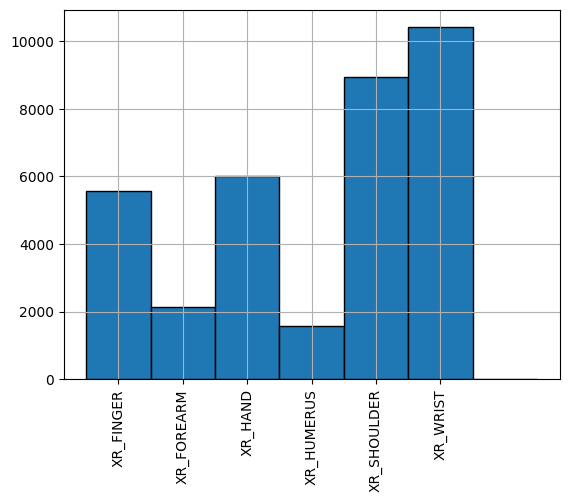

In [5]:

everythingScans_df['Bone'].hist(bins=range(1,9),rwidth=1, align='left',edgecolor='black')
plt.xticks(rotation=90)
plt.show()

# Explore some examples of images
When groupping by two values we need to define how the values will be combined.
get combinations of pics with same label and bone then choose one randomly 

In [6]:
onePairPic_df=everythingScans_df.groupby(['Label','Bone']).apply(lambda x:x.sample(1))
onePairPic_df.reset_index(drop=True)

path  Split         Bone  \
0   MURA-v1.1\train\XR_ELBOW\patient05543\study1_n...  train     XR_ELBOW   
1   MURA-v1.1\train\XR_FINGER\patient04283\study1_...  train    XR_FINGER   
2   MURA-v1.1\train\XR_FOREARM\patient08998\study2...  train   XR_FOREARM   
3   MURA-v1.1\train\XR_HAND\patient01685\study1_ne...  train      XR_HAND   
4   MURA-v1.1\valid\XR_HUMERUS\patient11698\study1...  valid   XR_HUMERUS   
5   MURA-v1.1\train\XR_SHOULDER\patient02056\study...  train  XR_SHOULDER   
6   MURA-v1.1\train\XR_WRIST\patient08158\study1_n...  train     XR_WRIST   
7   MURA-v1.1\train\XR_ELBOW\patient05019\study1_p...  train     XR_ELBOW   
8   MURA-v1.1\train\XR_FINGER\patient03806\study1_...  train    XR_FINGER   
9   MURA-v1.1\train\XR_FOREARM\patient09141\study1...  train   XR_FOREARM   
10  MURA-v1.1\valid\XR_HAND\patient11505\study1_po...  valid      XR_HAND   
11  MURA-v1.1\train\XR_HUMERUS\patient02706\study1...  train   XR_HUMERUS   
12  MURA-v1.1\train\XR_SHOULDER\patient00508\study...  train  XR_SHOULDER   
13  MURA-v1.1\valid\XR_WRIST\patient11246\study1_p...  valid     XR_WRIST   

         Patient       FolderName   Study     Label  
0   patient05543  study1_negative  study1  negative  
1   patient04283  study1_negative  study1  negative  
2   patient08998  study2_negative  study2  negative  
3   patient01685  study1_negative  study1  negative  
4   patient11698  study1_negative  study1  negative  
5   patient02056  study1_negative  study1  negative  
6   patient08158  study1_negative  study1  negative  
7   patient05019  study1_positive  study1  positive  
8   patient03806  study1_positive  study1  positive  
9   patient09141  study1_positive  study1  positive  
10  patient11505  study1_positive  study1  positive  
11  patient02706  study1_positive  study1  positive  
12  patient00508  study1_positive  study1  positive  
13  patient11246  study1_positive  study1  positive

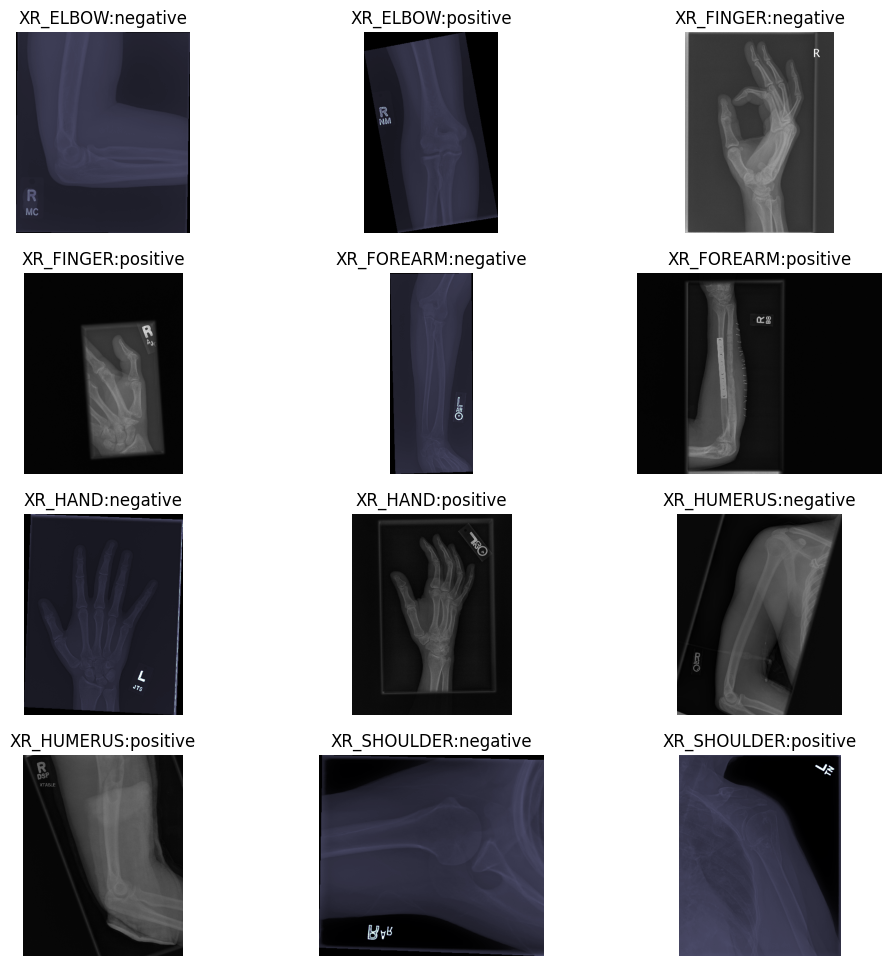

In [7]:
sub_df = everythingScans_df.groupby(['Bone', 'Label']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{Bone}:{Label}'.format(**c_row))

In [8]:
# try working only on humerus

humerus_df=everythingScans_df.loc[everythingScans_df['Bone']=='XR_HUMERUS'].copy()
humerus_df.sample(10)

path  Split        Bone  \
18551  MURA-v1.1\train\XR_HUMERUS\patient03164\study1...  train  XR_HUMERUS   
18212  MURA-v1.1\train\XR_HUMERUS\patient03003\study1...  train  XR_HUMERUS   
38748  MURA-v1.1\valid\XR_HUMERUS\patient11686\study1...  valid  XR_HUMERUS   
17974  MURA-v1.1\train\XR_HUMERUS\patient02894\study1...  train  XR_HUMERUS   
17978  MURA-v1.1\train\XR_HUMERUS\patient02895\study1...  train  XR_HUMERUS   
38706  MURA-v1.1\valid\XR_HUMERUS\patient11669\study1...  valid  XR_HUMERUS   
17994  MURA-v1.1\train\XR_HUMERUS\patient02902\study1...  train  XR_HUMERUS   
38557  MURA-v1.1\valid\XR_HUMERUS\patient11459\study1...  valid  XR_HUMERUS   
38566  MURA-v1.1\valid\XR_HUMERUS\patient11560\study1...  valid  XR_HUMERUS   
17624  MURA-v1.1\train\XR_HUMERUS\patient02738\study1...  train  XR_HUMERUS   

            Patient       FolderName   Study     Label  
18551  patient03164  study1_negative  study1  negative  
18212  patient03003  study1_negative  study1  negative  
38748  patient11686  study1_negative  study1  negative  
17974  patient02894  study1_positive  study1  positive  
17978  patient02895  study1_positive  study1  positive  
38706  patient11669  study1_negative  study1  negative  
17994  patient02902  study1_positive  study1  positive  
38557  patient11459  study1_negative  study1  negative  
38566  patient11560  study1_negative  study1  negative  
17624  patient02738  study1_positive  study1  positive

In [35]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from skimage.color import gray2rgb
class HumerusDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.labels = self.df['Label'].map({'positive': 1, 'negative': 0})
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        path=self.df['path'].iloc[idx]
        img = imread(path)
        if len(img.shape)==2:
            img = gray2rgb(img)
        print(img.size)
        if self.transform:
            img = self.transform(img)
        return img, self.labels.iloc[idx]

In [40]:
img,label=HumerusDataset(humerus_df)[100]
print(img.size)

645120
645120


In [ ]:
BATCH_SIZE=32

train_dataloader